In [1]:
from math import log, sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import sklearn.metrics as metrics
import psutil
from multiprocessing import Pool

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
colors = np.array(['#0101DF','#DF0101','#01DF01'])

time0 = time.time()
rs = 42
def compute_metrics (y_te2,y_p,string):
    print('\n %s'%string)
    print('CONFUSION MATRIX')
    print(metrics.confusion_matrix(y_te2,y_p))
    print(classification_report(y_te2, y_p))
    print('\nROC CURVE: %2.2f'%roc_auc_score(y_te2,y_p))

def plotting_ROC_curve(X_te,y_te,model):
    plt.figure()
    metrics.plot_roc_curve(model,X_te,y_te)
    plt.plot([0,1],[0,1],label='baseline',c='red')
    plt.legend(loc='lower right')
    plt.show()

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

def adaboost(X_tr, y_tr, X_te, y_te):
    model = AdaBoostClassifier(random_state=rs)
    model.fit(X_tr,y_tr)
    y_pred = model.predict(X_te)
    print(model.feature_importances_)
    compute_metrics(y_te,y_pred,'ADABOOST')
    plotting_ROC_curve(X_te,y_te,model=model)


def RandomForest (X_tr,y_tr,X_te,y_te):
    for i in range(1,3):
        print('dep: '+str(i))
        #RF por defecto utiliza 100 árboles de decisión. Este parámetro se cambia con n_estimators
        rfc = RandomForestClassifier(max_depth=i, random_state=rs,verbose=True,n_jobs=-1)
        rfc.fit(X_tr,y_tr)
        plotting_ROC_curve(X_te,y_te,model=rfc)
        y_pred = rfc.predict(X_te)
        print(rfc.feature_importances_)
        compute_metrics(y_te,y_pred,'RANDOM FOREST')

def CB(X_tr, y_tr, X_te, y_te):
    Cvar = [0.01,0.1,0.5,0.9]
    for i in range(0,len(Cvar)):
            model = CatBoostClassifier(random_state=rs,verbose=1,learning_rate=Cvar[i],max_depth=2)
            model.fit(X_tr,y_tr)
            y_pred = model.predict(X_te)
            compute_metrics(y_te,y_pred,'CatBoost (learning_rate=%1.2f)'%Cvar[i])
            plotting_ROC_curve(X_te,y_te,model=model)
        
def xgboost(X_tr, y_tr, X_te, y_te):
    model = XGBClassifier(random_state=rs,n_jobs=-1)
    model.fit(X_tr,y_tr)
    y_pred = model.predict(X_te)
    print(model.feature_importances_)
    compute_metrics(y_te,y_pred,'XGBoost')
    plotting_ROC_curve(X_te,y_te,model=model)
    
def DT(X_tr, y_tr, X_te, y_te):
    for i in range(1,3):
        model = DecisionTreeClassifier(random_state=rs,max_depth=i)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        print(model.feature_importances_)
        compute_metrics(y_te,y_pred,'DECISION TREE')
        plotting_ROC_curve(X_te,y_te,model=model)
    
def KNN(X_tr, y_tr, X_te, y_te):
    nei = [3,25,50]
    for i in range(0,len(nei)):
        model = KNeighborsClassifier(n_neighbors=nei[i],weights='distance',n_jobs=-1)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        compute_metrics(y_te,y_pred,'K-Neighbours (n_neighbors:%i)'%nei[i])
        plotting_ROC_curve(X_te,y_te,model=model)
    
def SVCL(X_tr, y_tr, X_te, y_te):
    Cvar = [0.01,0.1,0.5,0.9]
    for i in range(0,len(Cvar)):
            model = SVC(C=Cvar[i],kernel='sigmoid',degree=3,max_iter=100,random_state=rs,verbose=True)
            model.fit(X_tr,y_tr)
            y_pred = model.predict(X_te)
            compute_metrics(y_te,y_pred,'SVCL (C=%1.2f)'%Cvar[i])
            plotting_ROC_curve(X_te,y_te,model=model)
    
def BalancedRF(X_tr,y_tr,X_te,y_te):
    for i in range(1,3):
        print('dep: '+str(i))
        brfc = BalancedRandomForestClassifier(max_depth=i, random_state=rs,verbose=True,n_jobs=-1)
        brfc.fit(X_tr,y_tr)
        y_pred = brfc.predict(X_te)
        print(brfc.feature_importances_)
        compute_metrics(y_te,y_pred,'BALANCED RANDOM FOREST')
        plotting_ROC_curve(X_te,y_te,model=brfc)

def EasyEnsamble(X_tr, y_tr, X_te, y_te):
    nest = [10,25,50]
    for i in range(0,len(nest)):
        model = EasyEnsembleClassifier(n_estimators=nest[i],warm_start=True,n_jobs=-1,random_state=rs, verbose=1,replacement=True)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        compute_metrics(y_te,y_pred,'Easy Ensemble Classifier (n_estimators: %i)'%nest[i])
        plotting_ROC_curve(X_te,y_te,model=model)
    
def RUSBoost(X_tr, y_tr, X_te, y_te):
    nest = [10,25,50]
    for i in range(0,len(nest)):
        model = RUSBoostClassifier(n_estimators=nest[i],learning_rate=0.01,replacement=True,random_state=rs)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        print(model.feature_importances_)
        compute_metrics(y_te,y_pred,'RUS Boost Classifier (n_estimators: %i)'%nest[i])
        plotting_ROC_curve(X_te,y_te,model=model)

def Ratio10(y,string):
    suma = Counter(y)[0]+Counter(y)[1]
    print('\n'+string)  
    print(Counter(y))
    print('0: %3.2f%%\n1: %3.2f%%' % (100*Counter(y)[0]/suma,100*Counter(y)[1]/suma))

def histo(data,var):
    fig=plt.figure()
    sns.countplot(var,data=data,palette=colors)
    plt.title('0/1 Distribution (0: No Stalling || 1: Stalling Event',fontsize=14)
    plt.show()

Using TensorFlow backend.


Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_rst',
       'tcp_flag_syn', 'tcp_win_si2', 'delay', 'capture', 'stalling_event'],
      dtype='object')

dataset[stalling_event]
Counter({0: 1426905, 1: 113031})
0: 92.66%
1: 7.34%


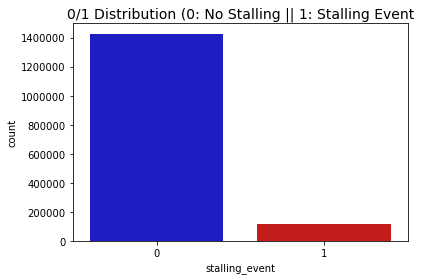

In [2]:
dataset = pd.read_csv('../../output/df_general.csv', sep=',')
split = 0.8
del dataset['No.']
del dataset['Protocol']
del dataset['tcp_flag_cwr']
del dataset['tcp_flag_ecn']
del dataset['tcp_flag_urg']
del dataset['ip_len']
del dataset['tcp_flag_psh']
del dataset['tcp_flag_fin']
del dataset['prebuffering']
del dataset['Time']

dataset = dataset.fillna(dataset.mean())

print(dataset.columns)
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

(1539936, 10)
(1538832, 10)
0.4992

dataset[stalling_event]
Counter({0: 1425825, 1: 113007})
0: 92.66%
1: 7.34%


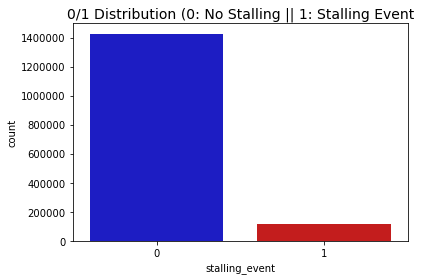

(0.0, 65335.0)

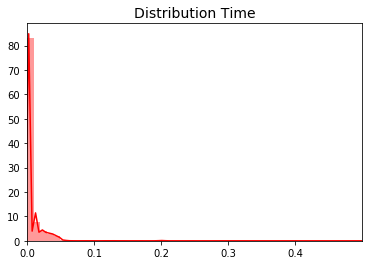

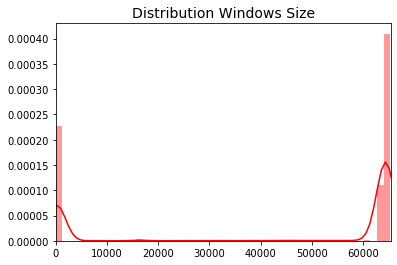

In [3]:
id = list(dataset[dataset['∆t']>0.5].index)
print(dataset.shape)
dataset = dataset.drop(id)
print(dataset.shape)
print(max(dataset['∆t']))
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

time_val = dataset['∆t'].values
win_val = dataset['tcp_win_si2'].values

fig = plt.figure()
sns.distplot(time_val,color='r')
plt.title('Distribution Time',fontsize=14)
plt.xlim([min(time_val),max(time_val)])

fig = plt.figure()
sns.distplot(win_val,color='r')
plt.title('Distribution Windows Size',fontsize=14)
plt.xlim([min(win_val),max(win_val)])


In [4]:
from random import randint
'''X_train = [None] * (len(dataset.columns)-1)
X_test = [None] * (len(dataset.columns)-1)'''

X_train = np.array([None]*7)
X_test = np.array([None]*7)
y_train = list()
y_test = list()

grouped = dataset.groupby(['delay','capture']) 
#print(grouped.mean())

for id, data in grouped:
    spl = int(data.shape[0] * split);
    restspl = int(data.shape[0] * (1-split))
    randnum = randint(0,restspl)
    '''print('data.shape: '+str(data.shape)+' | spl: '+str(spl)+
          ' | restspl: '+str(restspl)+' | randnum: '+str(randnum)+
          ' | 0:randnum='+str(range(0,randnum)) +' | randnum:randnum+spl= '+str(range(randnum,randnum+spl))+
          ' | randnum+spl: = '+str(range(randnum+spl,data.shape[0])))'''
    X_train = np.vstack((X_train,data.values[randnum:randnum+spl,:-3]))
    X_test = np.vstack((X_test,data.values[0:randnum-1,:-3]))
    X_test = np.vstack((X_test,data.values[randnum+spl:,:-3]))
    
    y_train.extend(data.values[randnum:randnum+spl,-1])
    y_test.extend(data.values[0:randnum-1,-1])
    y_test.extend(data.values[randnum+spl:,-1])
    '''X_train.extend(data.loc[randnum:randnum+spl][data.columns[:-3]].values.tolist())
    X_test.extend(data.loc[0:randnum][data.columns[:-3]].values.tolist())
    X_test.extend(data.loc[randnum+spl:][data.columns[:-3]].values.tolist())
    y_train.extend(data.loc[randnum:randnum+spl,data.columns=='stalling_event'].values.tolist())
    y_test.extend(data.loc[0:randnum,data.columns=='stalling_event'].values.tolist())
    y_test.extend(data.loc[randnum+spl:,data.columns=='stalling_event'].values.tolist())'''
X_train = X_train[1:]
X_test = X_test[1:]


In [5]:
y_test = list(map(int,y_test))
y_train = list(map(int,y_train))
Ratio10(y_test,'y_test')
Ratio10(y_train,'y_train')


y_test
Counter({0: 304727, 1: 3008})
0: 99.02%
1: 0.98%

y_train
Counter({0: 1121041, 1: 109996})
0: 91.06%
1: 8.94%


In [6]:
X_train = pd.DataFrame(data=X_train,columns=dataset.columns[:-3])
X_test= pd.DataFrame(data=X_test,columns=dataset.columns[:-3])

y_train = pd.DataFrame(data=y_train,columns=['y_train'])
y_test= pd.DataFrame(data=y_test,columns=['y_test'])

In [7]:
robSca = preprocessing.MinMaxScaler()
X_train['scaled_time'] = robSca.fit_transform(X_train['∆t'].values.reshape(-1,1))
X_train['scaled_pktlen'] = robSca.fit_transform(X_train['pkt_len'].values.reshape(-1,1))
X_train['scaled_tcphea'] = robSca.fit_transform(X_train['tcp_hea_len'].values.reshape(-1,1))
X_train['scaled_tcpwin'] = robSca.fit_transform(X_train['tcp_win_si2'].values.reshape(-1,1))
X_train.drop(['∆t','pkt_len','tcp_hea_len','tcp_win_si2'], axis=1, inplace=True)
X_train = X_train[['scaled_time','scaled_pktlen','scaled_tcphea','scaled_tcpwin','tcp_flag_ack', 'tcp_flag_rst', 'tcp_flag_syn']]

X_test['scaled_time'] = robSca.fit_transform(X_test['∆t'].values.reshape(-1,1))
X_test['scaled_pktlen'] = robSca.fit_transform(X_test['pkt_len'].values.reshape(-1,1))
X_test['scaled_tcphea'] = robSca.fit_transform(X_test['tcp_hea_len'].values.reshape(-1,1))
X_test['scaled_tcpwin'] = robSca.fit_transform(X_test['tcp_win_si2'].values.reshape(-1,1))
X_test.drop(['∆t','pkt_len','tcp_hea_len','tcp_win_si2'], axis=1, inplace=True)
X_test = X_test[['scaled_time','scaled_pktlen','scaled_tcphea','scaled_tcpwin','tcp_flag_ack', 'tcp_flag_rst', 'tcp_flag_syn']]


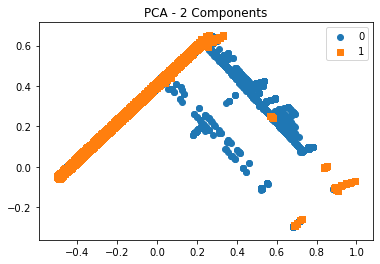

In [8]:
pca = PCA(n_components=2)
X_train_pca=pca.fit_transform(X_train)
plot_2d_space(X_train_pca, y_train.values.astype('int').T.ravel(),'PCA - 2 Components')

dep: 1
[0.12 0.   0.03 0.24 0.2  0.23 0.18]

 RANDOM FOREST
CONFUSION MATRIX
[[304727      0]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50
dep: 2
[0.12142601 0.03583471 0.04407117 0.29209844 0.17394997 0.23538634
 0.09723336]

 RANDOM FOREST
CONFUSION MATRIX
[[304727      0]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel

<Figure size 432x288 with 0 Axes>

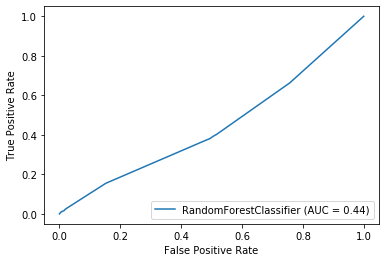

<Figure size 432x288 with 0 Axes>

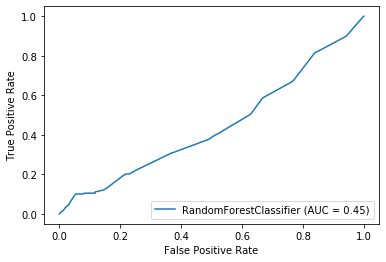

In [9]:
RandomForest(X_train,y_train,X_test,y_test)

In [10]:
adaboost(X_train.values,y_train.values,X_test.values,y_test.values)

[0.08 0.   0.02 0.86 0.02 0.   0.02]

 ADABOOST
CONFUSION MATRIX
[[304713     14]
 [  3007      1]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.07      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.53      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50


[0.08498883 0.18982588 0.04737885 0.4194979  0.2045673  0.
 0.05374128]

 XGBoost
CONFUSION MATRIX
[[304674     53]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50


<Figure size 432x288 with 0 Axes>

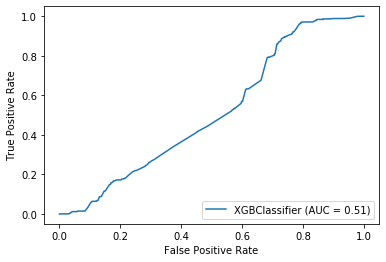

In [11]:
xgboost(X_train.values,y_train.values,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 DECISION TREE
CONFUSION MATRIX
[[304727      0]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50
[0.         0.50928138 0.         0.27986681 0.21085181 0.
 0.        ]

 DECISION TREE
CONFUSION MATRIX
[[304727      0]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50


<Figure size 432x288 with 0 Axes>

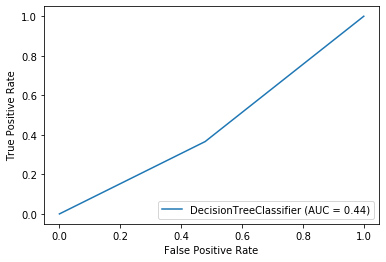

<Figure size 432x288 with 0 Axes>

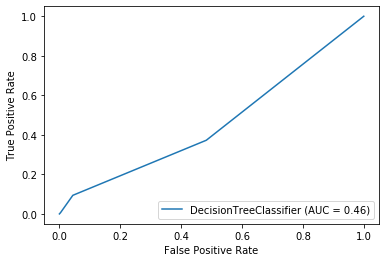

In [12]:
DT(X_train,y_train,X_test,y_test)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[288913  15814]
 [  2852    156]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    304727
           1       0.01      0.05      0.02      3008

    accuracy                           0.94    307735
   macro avg       0.50      0.50      0.49    307735
weighted avg       0.98      0.94      0.96    307735


ROC CURVE: 0.50

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[296699   8028]
 [  2918     90]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    304727
           1       0.01      0.03      0.02      3008

    accuracy                           0.96    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.96      0.97    307735


ROC CURVE: 0.50

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[297811   6916]
 [  2937     71]]
              precision    recall  f1-score   support

      

<Figure size 432x288 with 0 Axes>

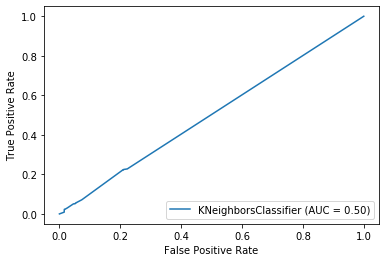

<Figure size 432x288 with 0 Axes>

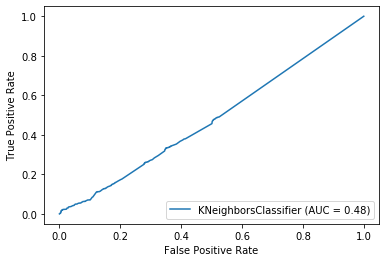

<Figure size 432x288 with 0 Axes>

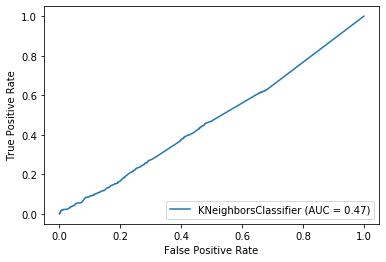

In [13]:
KNN(X_train.values,y_train.values,X_test.values,y_test.values)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[ 54311 250416]
 [   490   2518]]
              precision    recall  f1-score   support

           0       0.99      0.18      0.30    304727
           1       0.01      0.84      0.02      3008

    accuracy                           0.18    307735
   macro avg       0.50      0.51      0.16    307735
weighted avg       0.98      0.18      0.30    307735


ROC CURVE: 0.51
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[ 54719 250008]
 [   492   2516]]
              precision    recall  f1-score   support

           0       0.99      0.18      0.30    304727
           1       0.01      0.84      0.02      3008

    accuracy                           0.19    307735
   macro avg       0.50      0.51      0.16    307735
weighted avg       0.98      0.19      0.30    307735


ROC CURVE: 0.51
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[ 55044 249683]
 [   493   2515]]
              precision    recall  f1-score   support

           0       0.99      

<Figure size 432x288 with 0 Axes>

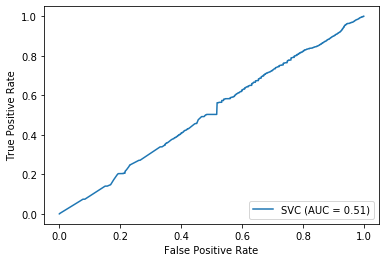

<Figure size 432x288 with 0 Axes>

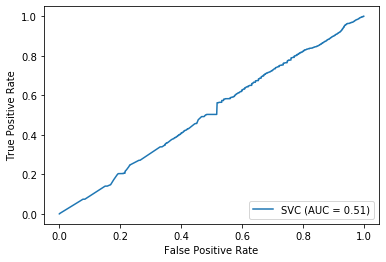

<Figure size 432x288 with 0 Axes>

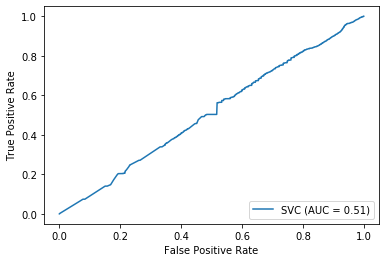

<Figure size 432x288 with 0 Axes>

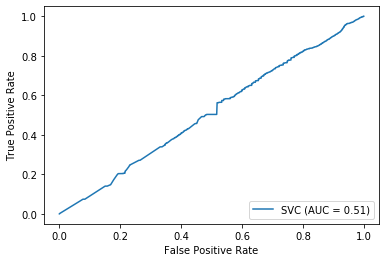

In [14]:
SVCL(X_train.values,y_train.values,X_test.values,y_test.values)

dep: 1
[0.16 0.   0.06 0.27 0.21 0.19 0.11]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.15960889 0.03843811 0.04882772 0.36661846 0.17706663 0.13680152
 0.07263867]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[169678 135049]
 [  1950   1058]]
              precision    recall  f1-score   support

           0       0.99      0.56      0.71    304727
           1       0.01      0.35      0.02      3008

    accuracy                           0.55    307735
   macro avg       0.50      0.45      0.36    307735
weighted avg       0.98      0.55      0.71    307735


ROC CURVE: 0.45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel

<Figure size 432x288 with 0 Axes>

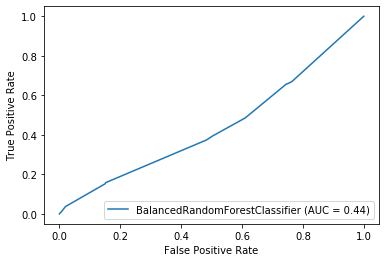

<Figure size 432x288 with 0 Axes>

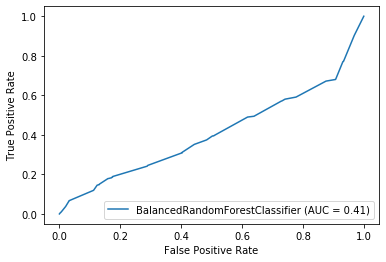

In [15]:
BalancedRF(X_train.values,y_train.values,X_test.values,y_test.values)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   31.4s remaining:   31.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   41.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.5s remaining:   17.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   18.0s remaining:   18.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[212082  92645]
 [  2198    810]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.69    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.69      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[213194  91533]
 [  2202    806]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[212968  91759]
 [  2195    813]]
              prec

<Figure size 432x288 with 0 Axes>

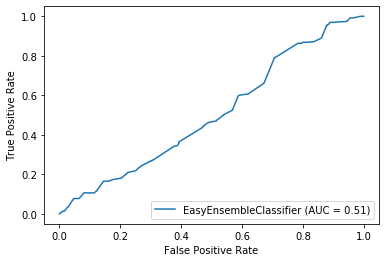

<Figure size 432x288 with 0 Axes>

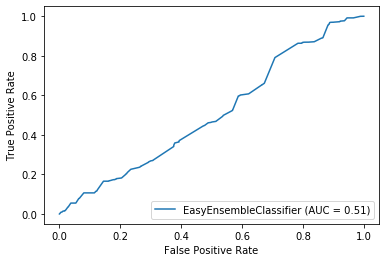

<Figure size 432x288 with 0 Axes>

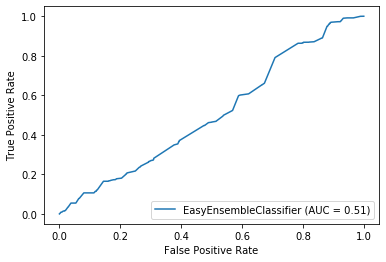

In [16]:
EasyEnsamble(X_train.values,y_train.values,X_test.values,y_test.values)

In [ ]:
RUSBoost(X_train.values,y_train.values,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MAT

<Figure size 432x288 with 0 Axes>

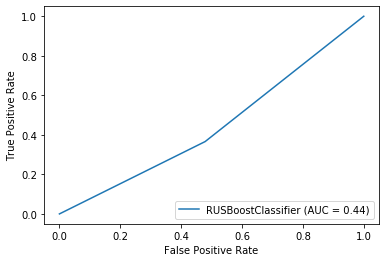

<Figure size 432x288 with 0 Axes>

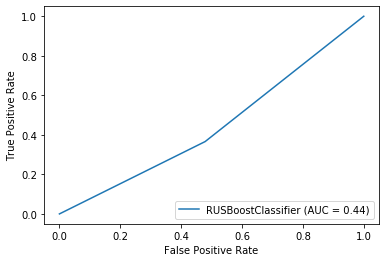

<Figure size 432x288 with 0 Axes>

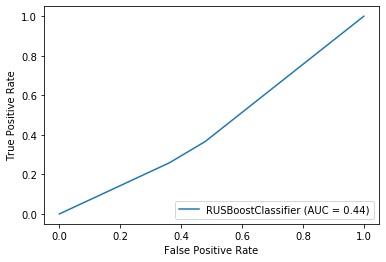

In [17]:
CB(X_train.values,y_train.values,X_test.values,y_test.values)

In [18]:
Train = pd.concat([X_train,y_train],axis=1) 
print(Train.head())

   scaled_time  scaled_pktlen  scaled_tcphea  scaled_tcpwin tcp_flag_ack  \
0     0.033454       1.000000            0.0       0.994873            1   
1     0.002804       1.000000            0.0       0.982613            1   
2     0.000401       0.008152            0.0       0.003918            1   
3     0.005208       1.000000            0.0       0.982613            1   
4     0.044071       1.000000            0.0       0.982613            1   

  tcp_flag_rst tcp_flag_syn  y_train  
0            0            0        0  
1            0            0        0  
2            0            0        0  
3            0            0        0  
4            0            0        0  


Random under-sampling
Counter({1: 109996})
Counter({0: 109996})
Counter({0: 109996, 1: 109996})
(219992, 8)
(219992, 7)


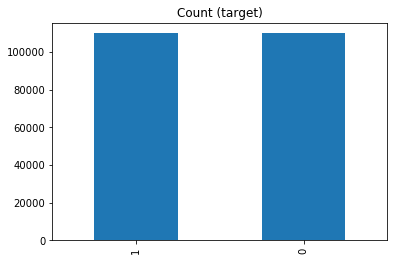

In [19]:
print('Random under-sampling')
count_class_0, count_class_1 = Train.y_train.value_counts()
X_train0 = Train[Train['y_train'] == 0]
X_train1 = Train[Train['y_train'] == 1]
print(Counter(X_train1['y_train'].values))
df_class_0_under = X_train0.sample(count_class_1)
print(Counter(df_class_0_under.y_train))
df_train_under = pd.concat([df_class_0_under, X_train1], axis=0)
print(Counter(df_train_under.y_train))

df_train_under.y_train.value_counts().plot(kind='bar', title='Count (target)')
print(df_train_under.shape)
df_train_under_y = df_train_under.y_train
df_train_under = df_train_under.drop(['y_train'],axis=1)
print(df_train_under.shape)

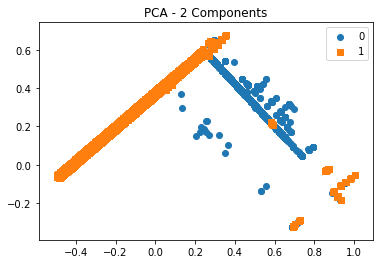

In [20]:
pca = PCA(n_components=2)
X_train_pca=pca.fit_transform(df_train_under)
plot_2d_space(X_train_pca, df_train_under_y.values.astype('int').T.ravel(),'PCA - 2 Components')

dep: 1
[0.18 0.   0.03 0.24 0.21 0.22 0.12]

 RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.17392018 0.03298924 0.04232018 0.35519234 0.15656526 0.1647673
 0.0742455 ]

 RANDOM FOREST
CONFUSION MATRIX
[[157248 147479]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.51    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.51      0.67    307735


ROC CURVE: 0.45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel

<Figure size 432x288 with 0 Axes>

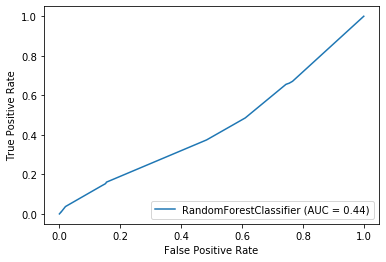

<Figure size 432x288 with 0 Axes>

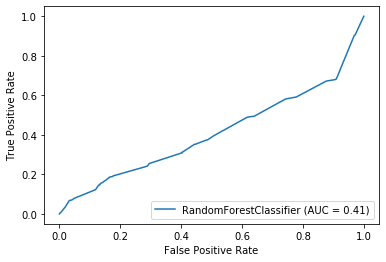

In [21]:
RandomForest(df_train_under,df_train_under_y,X_test,y_test)

In [22]:
adaboost(df_train_under,df_train_under_y.values,X_test,y_test)

[0.16 0.02 0.02 0.76 0.02 0.   0.02]

 ADABOOST
CONFUSION MATRIX
[[192845 111882]
 [  1978   1030]]
              precision    recall  f1-score   support

           0       0.99      0.63      0.77    304727
           1       0.01      0.34      0.02      3008

    accuracy                           0.63    307735
   macro avg       0.50      0.49      0.39    307735
weighted avg       0.98      0.63      0.76    307735


ROC CURVE: 0.49


[0.07282045 0.14217778 0.04000567 0.43253705 0.24819067 0.
 0.0642684 ]

 XGBoost
CONFUSION MATRIX
[[214346  90381]
 [  2239    769]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.26      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.81    307735


ROC CURVE: 0.48


<Figure size 432x288 with 0 Axes>

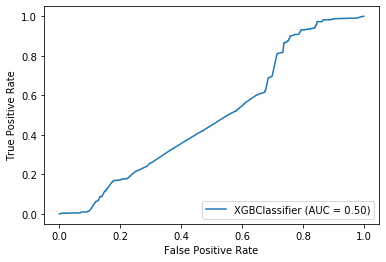

In [23]:
xgboost(df_train_under.values,df_train_under_y.values,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 DECISION TREE
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0.         0.42062084 0.         0.57937916 0.         0.
 0.        ]

 DECISION TREE
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44


<Figure size 432x288 with 0 Axes>

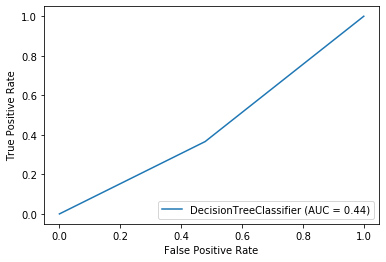

<Figure size 432x288 with 0 Axes>

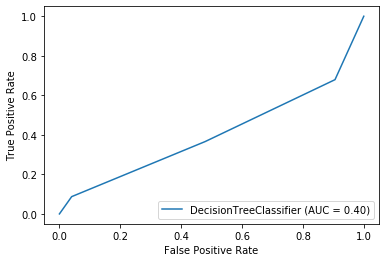

In [24]:
DT(df_train_under,df_train_under_y,X_test,y_test)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[240501  64226]
 [  2402    606]]
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    304727
           1       0.01      0.20      0.02      3008

    accuracy                           0.78    307735
   macro avg       0.50      0.50      0.45    307735
weighted avg       0.98      0.78      0.87    307735


ROC CURVE: 0.50

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[215638  89089]
 [  2214    794]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    304727
           1       0.01      0.26      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.49      0.42    307735
weighted avg       0.98      0.70      0.82    307735


ROC CURVE: 0.49

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[212274  92453]
 [  2204    804]]
              precision    recall  f1-score   support

      

<Figure size 432x288 with 0 Axes>

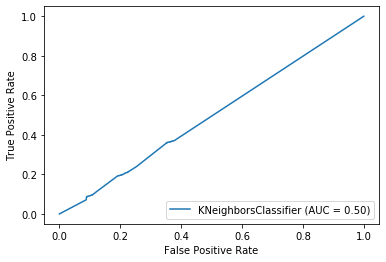

<Figure size 432x288 with 0 Axes>

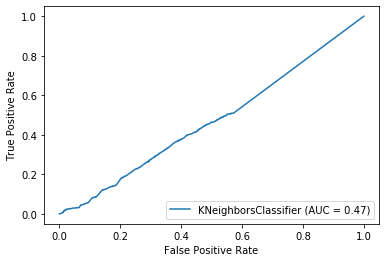

<Figure size 432x288 with 0 Axes>

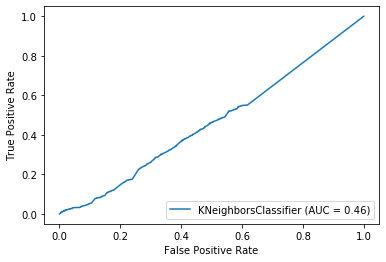

In [25]:
KNN(df_train_under.values,df_train_under_y.values,X_test.values,y_test.values)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[    28 304699]
 [     0   3008]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    304727
           1       0.01      1.00      0.02      3008

    accuracy                           0.01    307735
   macro avg       0.50      0.50      0.01    307735
weighted avg       0.99      0.01      0.00    307735


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[    28 304699]
 [     0   3008]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    304727
           1       0.01      1.00      0.02      3008

    accuracy                           0.01    307735
   macro avg       0.50      0.50      0.01    307735
weighted avg       0.99      0.01      0.00    307735


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[    28 304699]
 [     0   3008]]
              precision    recall  f1-score   support

           0       1.00      

<Figure size 432x288 with 0 Axes>

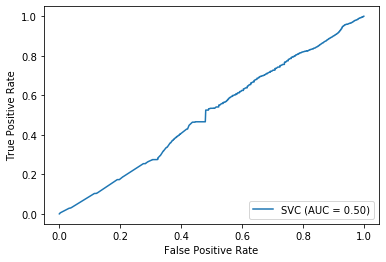

<Figure size 432x288 with 0 Axes>

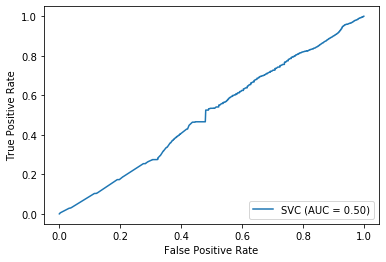

<Figure size 432x288 with 0 Axes>

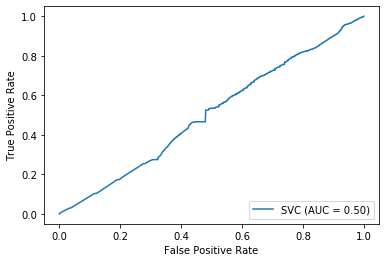

<Figure size 432x288 with 0 Axes>

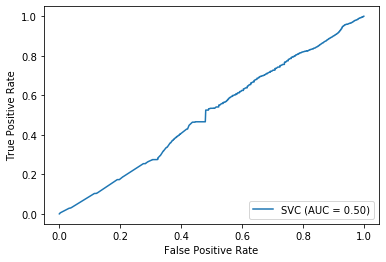

In [26]:
SVCL(df_train_under.values,df_train_under_y.values,X_test.values,y_test.values)

dep: 1
[0.16 0.   0.06 0.27 0.22 0.18 0.11]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.14699298 0.04060456 0.04466855 0.36710369 0.17790249 0.1401013
 0.08262644]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel

<Figure size 432x288 with 0 Axes>

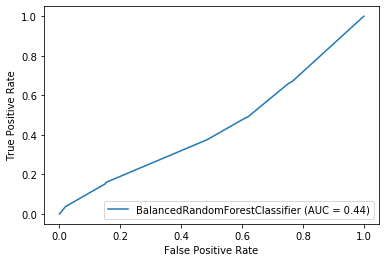

<Figure size 432x288 with 0 Axes>

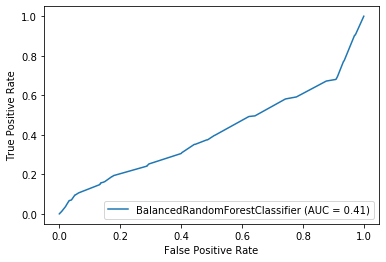

In [27]:
BalancedRF(df_train_under.values,df_train_under_y.values,X_test.values,y_test.values)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   26.3s remaining:   26.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.1s remaining:   17.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   23.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.6s remaining:   17.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[214750  89977]
 [  2214    794]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.26      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.82    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[214691  90036]
 [  2215    793]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.26      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.82    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[214763  89964]
 [  2215    793]]
              prec

<Figure size 432x288 with 0 Axes>

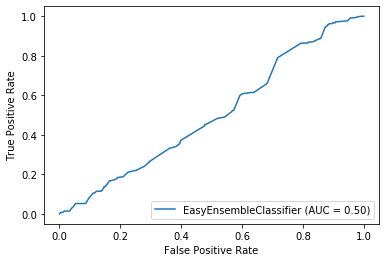

<Figure size 432x288 with 0 Axes>

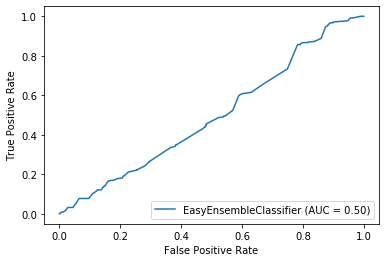

<Figure size 432x288 with 0 Axes>

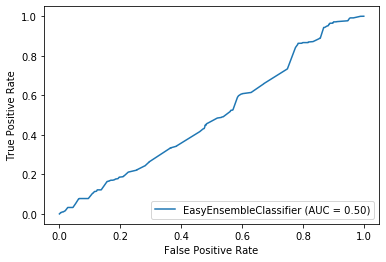

In [28]:
EasyEnsamble(df_train_under.values,df_train_under_y.values,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MAT

<Figure size 432x288 with 0 Axes>

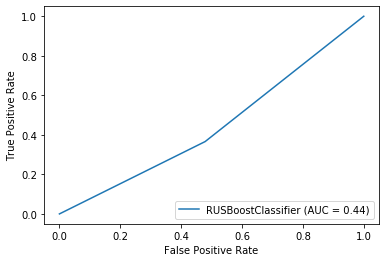

<Figure size 432x288 with 0 Axes>

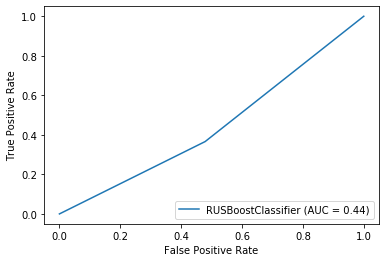

<Figure size 432x288 with 0 Axes>

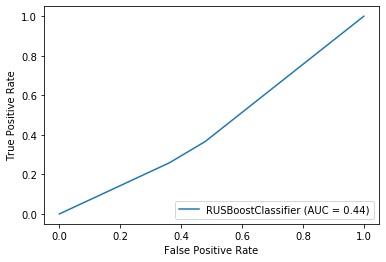

In [29]:
RUSBoost(df_train_under.values,df_train_under_y.values,X_test.values,y_test.values)

In [ ]:
CB(df_train_under.values,df_train_under_y.values,X_test.values,y_test.values)

Random over-sampling
Counter({0: 1121041, 1: 1121041})
(2242082, 8)
(2242082, 7)


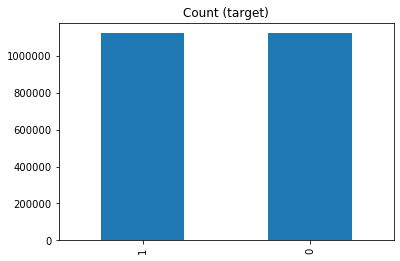

In [30]:
print('Random over-sampling')
df_class_1_over = X_train1.sample(count_class_0, replace=True)
df_train_over = pd.concat([X_train0, df_class_1_over], axis=0)
print(Counter(df_train_over.y_train))
df_train_over.y_train.value_counts().plot(kind='bar', title='Count (target)')
print(df_train_over.shape)
df_train_over_y = df_train_over.y_train
df_train_over = df_train_over.drop(['y_train'],axis=1)
print(df_train_over.shape)

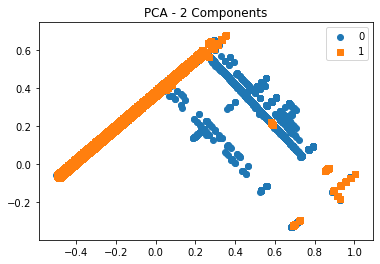

In [31]:
pca = PCA(n_components=2)
X_train_pca=pca.fit_transform(df_train_over)
plot_2d_space(X_train_pca, df_train_over_y.values.astype('int').T.ravel(),'PCA - 2 Components')

dep: 1
[0.18 0.   0.03 0.24 0.21 0.22 0.12]

 RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.16279642 0.0334916  0.04453405 0.356609   0.16724105 0.16850298
 0.0668249 ]

 RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel

<Figure size 432x288 with 0 Axes>

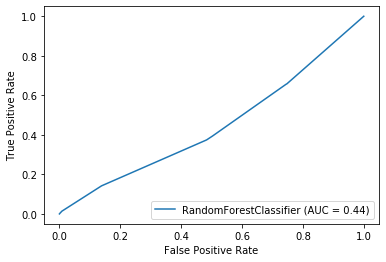

<Figure size 432x288 with 0 Axes>

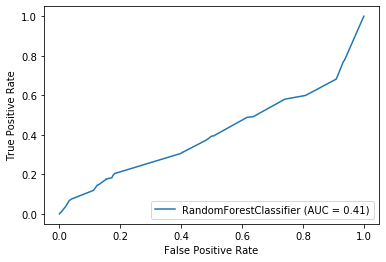

In [32]:
RandomForest(df_train_over,df_train_over_y,X_test,y_test)

In [33]:
adaboost(df_train_over,df_train_over_y,X_test,y_test)

[0.08 0.   0.02 0.86 0.02 0.   0.02]

 ADABOOST
CONFUSION MATRIX
[[212385  92342]
 [  2156    852]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.28      0.02      3008

    accuracy                           0.69    307735
   macro avg       0.50      0.49      0.42    307735
weighted avg       0.98      0.69      0.81    307735


ROC CURVE: 0.49


[0.07635837 0.1676342  0.04915382 0.4273713  0.2241337  0.
 0.05534862]

 XGBoost
CONFUSION MATRIX
[[222026  82701]
 [  2283    725]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    304727
           1       0.01      0.24      0.02      3008

    accuracy                           0.72    307735
   macro avg       0.50      0.48      0.43    307735
weighted avg       0.98      0.72      0.83    307735


ROC CURVE: 0.48


<Figure size 432x288 with 0 Axes>

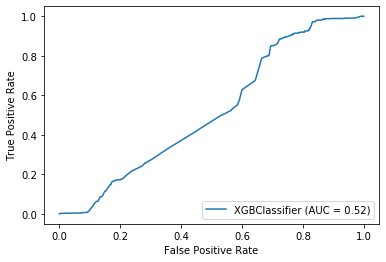

In [34]:
xgboost(df_train_over.values,df_train_over_y.values,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 DECISION TREE
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0.         0.42401989 0.         0.57598011 0.         0.
 0.        ]

 DECISION TREE
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44


<Figure size 432x288 with 0 Axes>

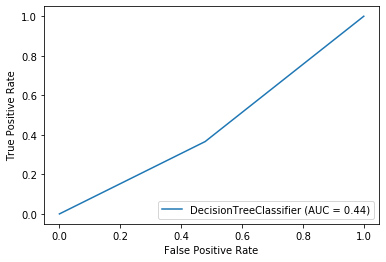

<Figure size 432x288 with 0 Axes>

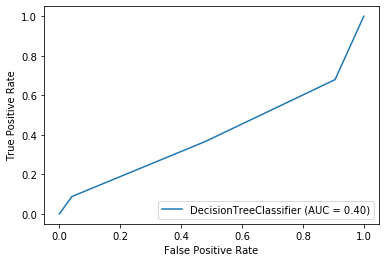

In [35]:
DT(df_train_over,df_train_over_y,X_test,y_test)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[234447  70280]
 [  2272    736]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.87    304727
           1       0.01      0.24      0.02      3008

    accuracy                           0.76    307735
   macro avg       0.50      0.51      0.44    307735
weighted avg       0.98      0.76      0.86    307735


ROC CURVE: 0.51

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[224186  80541]
 [  2184    824]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.84    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.73    307735
   macro avg       0.50      0.50      0.43    307735
weighted avg       0.98      0.73      0.84    307735


ROC CURVE: 0.50

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[227589  77138]
 [  2224    784]]
              precision    recall  f1-score   support

      

<Figure size 432x288 with 0 Axes>

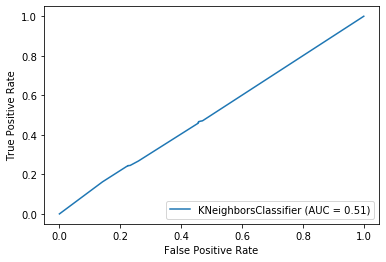

<Figure size 432x288 with 0 Axes>

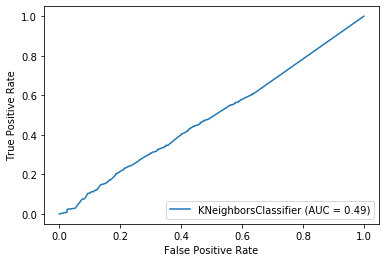

<Figure size 432x288 with 0 Axes>

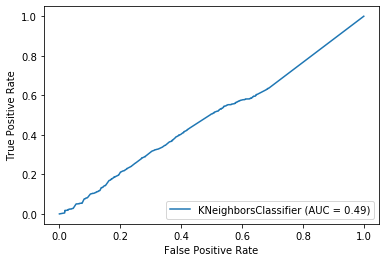

In [36]:
KNN(df_train_over.values,df_train_over_y.values,X_test.values,y_test.values)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[205184  99543]
 [  2163    845]]
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    304727
           1       0.01      0.28      0.02      3008

    accuracy                           0.67    307735
   macro avg       0.50      0.48      0.41    307735
weighted avg       0.98      0.67      0.79    307735


ROC CURVE: 0.48
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[205184  99543]
 [  2163    845]]
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    304727
           1       0.01      0.28      0.02      3008

    accuracy                           0.67    307735
   macro avg       0.50      0.48      0.41    307735
weighted avg       0.98      0.67      0.79    307735


ROC CURVE: 0.48
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[205184  99543]
 [  2163    845]]
              precision    recall  f1-score   support

           0       0.99      

<Figure size 432x288 with 0 Axes>

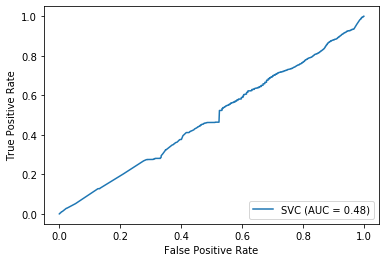

<Figure size 432x288 with 0 Axes>

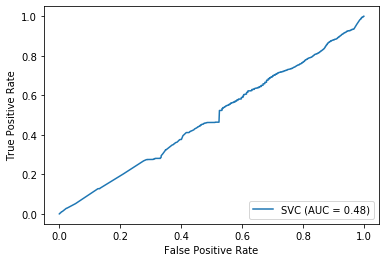

<Figure size 432x288 with 0 Axes>

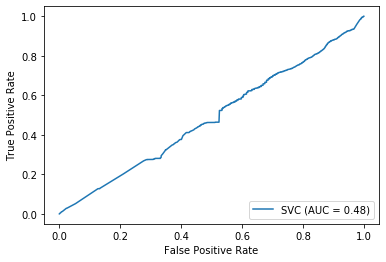

<Figure size 432x288 with 0 Axes>

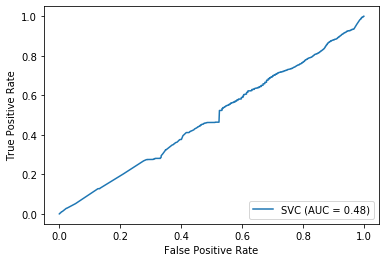

In [37]:
SVCL(df_train_over.values,df_train_over_y.values,X_test.values,y_test.values)

dep: 1
[0.16 0.   0.06 0.27 0.21 0.19 0.11]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.14478753 0.03938688 0.04745192 0.36415345 0.18381267 0.14832119
 0.07208637]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel

<Figure size 432x288 with 0 Axes>

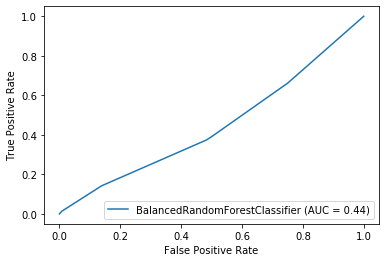

<Figure size 432x288 with 0 Axes>

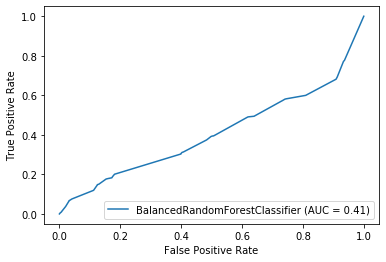

In [38]:
BalancedRF(df_train_over.values,df_train_over_y.values,X_test.values,y_test.values)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.4min remaining:  4.4min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.2s remaining:   17.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   23.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.5s remaining:   17.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 12.6min remaining: 12.6min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 14.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[212257  92470]
 [  2193    815]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.69    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.69      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[212676  92051]
 [  2193    815]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.69    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.69      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[212692  92035]
 [  2194    814]]
              prec

<Figure size 432x288 with 0 Axes>

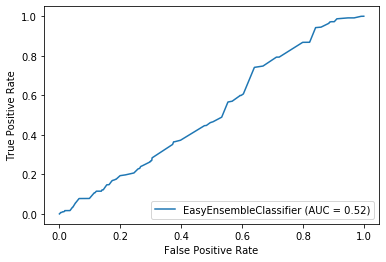

<Figure size 432x288 with 0 Axes>

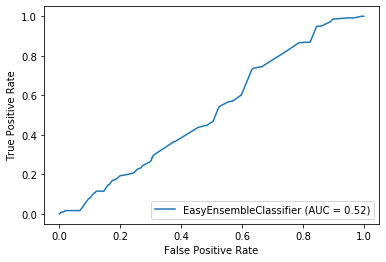

<Figure size 432x288 with 0 Axes>

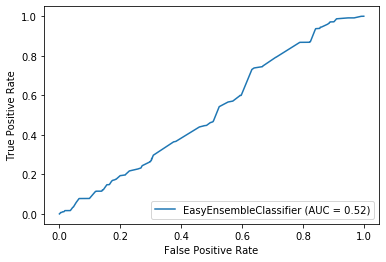

In [39]:
EasyEnsamble(df_train_over.values,df_train_over_y.values,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MAT

<Figure size 432x288 with 0 Axes>

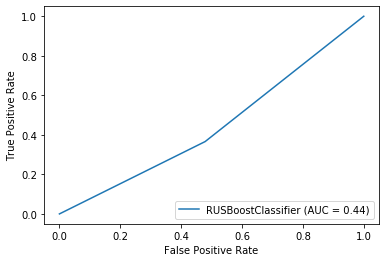

<Figure size 432x288 with 0 Axes>

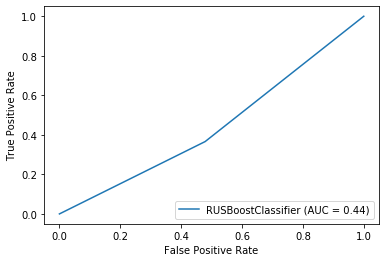

<Figure size 432x288 with 0 Axes>

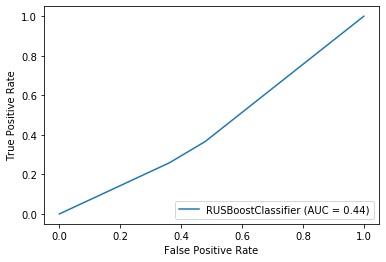

In [40]:
RUSBoost(df_train_over.values,df_train_over_y.values,X_test.values,y_test.values)

In [ ]:
CB(df_train_over.values,df_train_over_y.values,X_test.values,y_test.values)

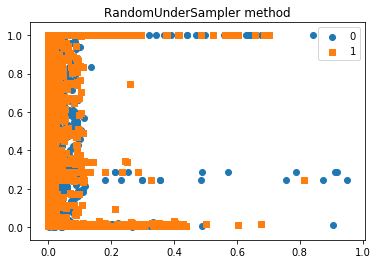

In [41]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train.values,y_train.values)
#print(Counter(y_rus))
plot_2d_space(X_rus,y_rus.astype('int').T.ravel(),'RandomUnderSampler method')

In [ ]:
pca = PCA(n_components=2)
X_rus_pca=pca.fit_transform(X_rus)
plot_2d_space(X_rus_pca, y_rus.T.ravel(),'PCA - 2 Components - RUS')

dep: 1
[0.18 0.   0.03 0.24 0.2  0.23 0.12]

 RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.16769024 0.03622569 0.04945301 0.35076796 0.14847119 0.17910004
 0.06829186]

 RANDOM FOREST
CONFUSION MATRIX
[[156942 147785]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.51    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.51      0.67    307735


ROC CURVE: 0.44


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel

<Figure size 432x288 with 0 Axes>

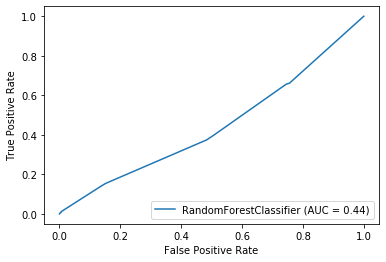

<Figure size 432x288 with 0 Axes>

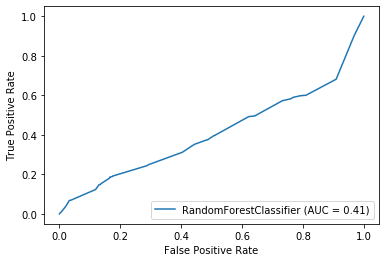

In [42]:
RandomForest(X_rus,y_rus,X_test,y_test)

In [43]:
adaboost(X_rus,y_rus,X_test,y_test)

[0.12 0.02 0.02 0.8  0.02 0.   0.02]

 ADABOOST
CONFUSION MATRIX
[[212433  92294]
 [  2191    817]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.69    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.69      0.81    307735


ROC CURVE: 0.48


[0.07623635 0.23557171 0.05211536 0.36490276 0.22355188 0.
 0.04762191]

 XGBoost
CONFUSION MATRIX
[[217434  87293]
 [  2282    726]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    304727
           1       0.01      0.24      0.02      3008

    accuracy                           0.71    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.71      0.82    307735


ROC CURVE: 0.48


<Figure size 432x288 with 0 Axes>

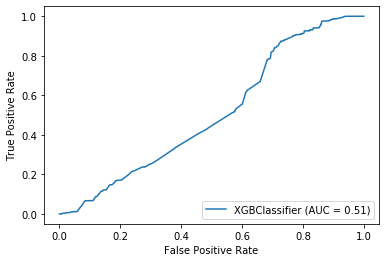

In [44]:
xgboost(X_rus,y_rus,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 DECISION TREE
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0.         0.43509252 0.         0.56490748 0.         0.
 0.        ]

 DECISION TREE
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44


<Figure size 432x288 with 0 Axes>

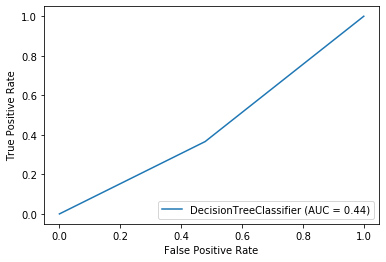

<Figure size 432x288 with 0 Axes>

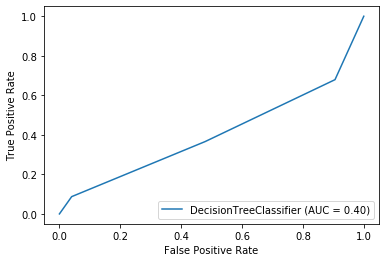

In [45]:
DT(X_rus,y_rus,X_test,y_test)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[217286  87441]
 [  2196    812]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.71    307735
   macro avg       0.50      0.49      0.42    307735
weighted avg       0.98      0.71      0.82    307735


ROC CURVE: 0.49

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[213433  91294]
 [  2164    844]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.28      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.49      0.42    307735
weighted avg       0.98      0.70      0.81    307735


ROC CURVE: 0.49

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[211690  93037]
 [  2214    794]]
              precision    recall  f1-score   support

      

<Figure size 432x288 with 0 Axes>

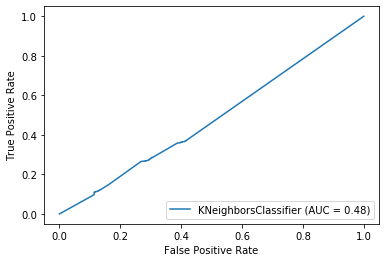

<Figure size 432x288 with 0 Axes>

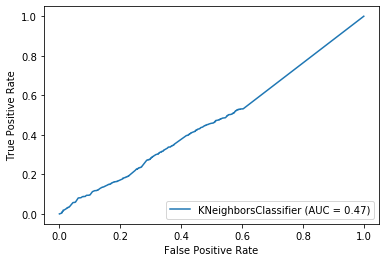

<Figure size 432x288 with 0 Axes>

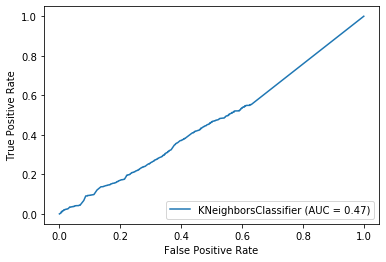

In [46]:
KNN(X_rus,y_rus,X_test.values,y_test.values)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[   906 303821]
 [     4   3004]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.01    304727
           1       0.01      1.00      0.02      3008

    accuracy                           0.01    307735
   macro avg       0.50      0.50      0.01    307735
weighted avg       0.99      0.01      0.01    307735


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[   906 303821]
 [     4   3004]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.01    304727
           1       0.01      1.00      0.02      3008

    accuracy                           0.01    307735
   macro avg       0.50      0.50      0.01    307735
weighted avg       0.99      0.01      0.01    307735


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[   906 303821]
 [     4   3004]]
              precision    recall  f1-score   support

           0       1.00      

<Figure size 432x288 with 0 Axes>

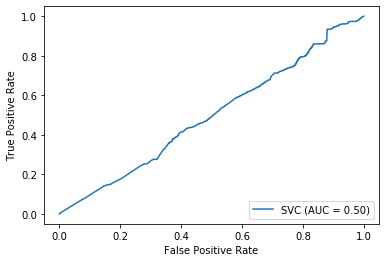

<Figure size 432x288 with 0 Axes>

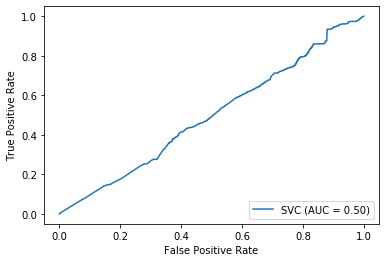

<Figure size 432x288 with 0 Axes>

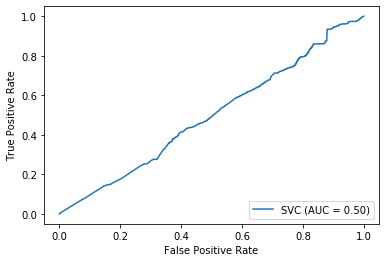

<Figure size 432x288 with 0 Axes>

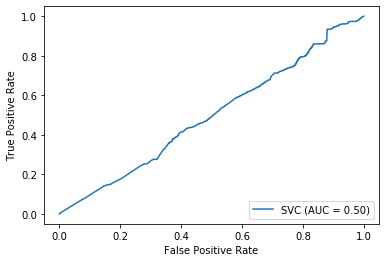

In [47]:
SVCL(X_rus,y_rus,X_test.values,y_test.values)

dep: 1
[0.16 0.   0.07 0.27 0.22 0.18 0.1 ]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.1579357  0.04388804 0.04984645 0.35904423 0.17216408 0.14414566
 0.07297583]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[169342 135385]
 [  1948   1060]]
              precision    recall  f1-score   support

           0       0.99      0.56      0.71    304727
           1       0.01      0.35      0.02      3008

    accuracy                           0.55    307735
   macro avg       0.50      0.45      0.36    307735
weighted avg       0.98      0.55      0.70    307735


ROC CURVE: 0.45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel

<Figure size 432x288 with 0 Axes>

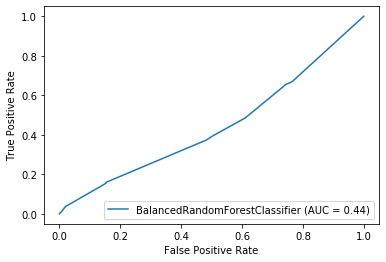

<Figure size 432x288 with 0 Axes>

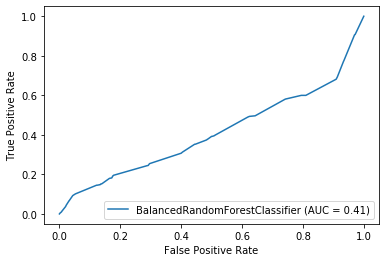

In [48]:
BalancedRF(X_rus,y_rus,X_test.values,y_test.values)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   27.4s remaining:   27.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.2s remaining:   17.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.2s remaining:   17.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[214028  90699]
 [  2211    797]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.26      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[213411  91316]
 [  2199    809]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[213511  91216]
 [  2200    808]]
              prec

<Figure size 432x288 with 0 Axes>

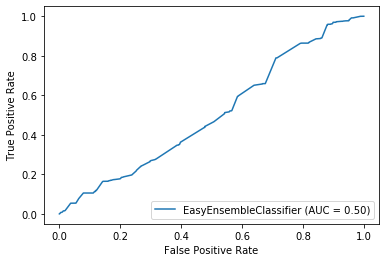

<Figure size 432x288 with 0 Axes>

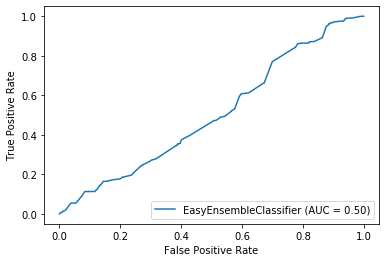

<Figure size 432x288 with 0 Axes>

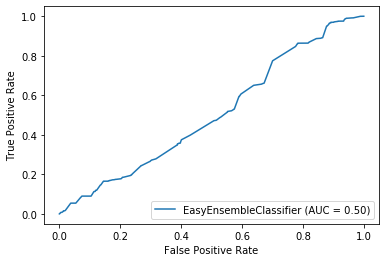

In [49]:
EasyEnsamble(X_rus,y_rus,X_test.values,y_test.values)

In [ ]:
RUSBoost(X_rus,y_rus,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MAT

<Figure size 432x288 with 0 Axes>

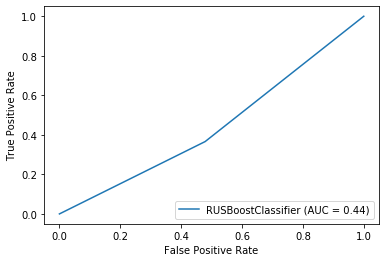

<Figure size 432x288 with 0 Axes>

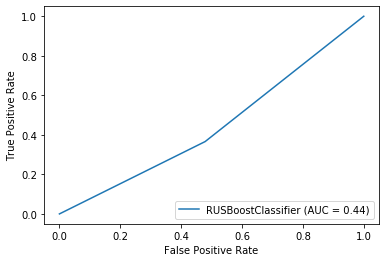

<Figure size 432x288 with 0 Axes>

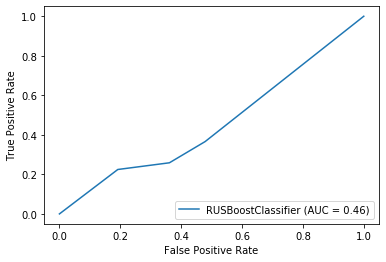

In [50]:
CB(X_rus,y_rus,X_test.values,y_test.values)

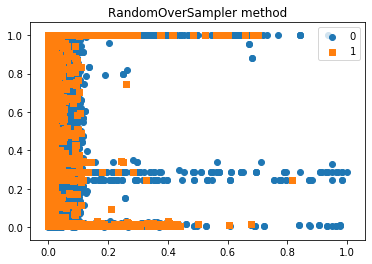

In [51]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train.values,y_train.values.astype('int').T.ravel())
#print(Counter(y_ros))
plot_2d_space(X_ros,y_ros.astype('int').T.ravel(),'RandomOverSampler method')

In [ ]:
pca = PCA(n_components=2)
X_ros_pca=pca.fit_transform(X_ros)
plot_2d_space(X_ros_pca, y_ros.T.ravel(),'PCA - 2 Components - ROS')

dep: 1
[0.18 0.   0.03 0.24 0.2  0.23 0.12]

 RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.15618765 0.0334141  0.0412509  0.35679994 0.16564349 0.17737379
 0.06933012]

 RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel

<Figure size 432x288 with 0 Axes>

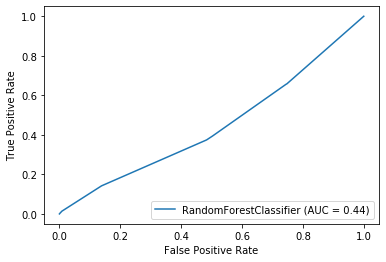

<Figure size 432x288 with 0 Axes>

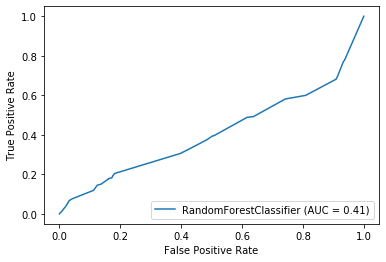

In [52]:
RandomForest(X_ros,y_ros,X_test,y_test)

In [53]:
adaboost(X_ros,y_ros,X_test,y_test)

[0.08 0.   0.02 0.86 0.02 0.   0.02]

 ADABOOST
CONFUSION MATRIX
[[212385  92342]
 [  2156    852]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.28      0.02      3008

    accuracy                           0.69    307735
   macro avg       0.50      0.49      0.42    307735
weighted avg       0.98      0.69      0.81    307735


ROC CURVE: 0.49


[0.07770957 0.16194254 0.06015772 0.4189233  0.22866066 0.
 0.05260628]

 XGBoost
CONFUSION MATRIX
[[217618  87109]
 [  2287    721]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    304727
           1       0.01      0.24      0.02      3008

    accuracy                           0.71    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.71      0.82    307735


ROC CURVE: 0.48


<Figure size 432x288 with 0 Axes>

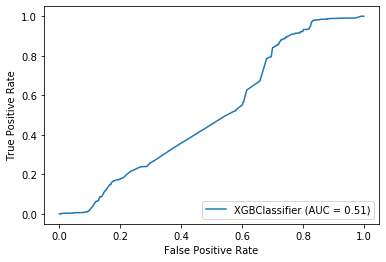

In [54]:
xgboost(X_ros,y_ros,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 DECISION TREE
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0.         0.42002186 0.         0.57997814 0.         0.
 0.        ]

 DECISION TREE
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44


<Figure size 432x288 with 0 Axes>

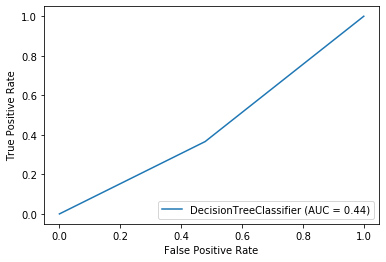

<Figure size 432x288 with 0 Axes>

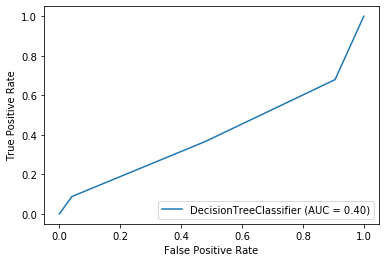

In [55]:
DT(X_ros,y_ros,X_test,y_test)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[206571  98156]
 [  1954   1054]]
              precision    recall  f1-score   support

           0       0.99      0.68      0.80    304727
           1       0.01      0.35      0.02      3008

    accuracy                           0.67    307735
   macro avg       0.50      0.51      0.41    307735
weighted avg       0.98      0.67      0.80    307735


ROC CURVE: 0.51

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[229094  75633]
 [  2196    812]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.75    307735
   macro avg       0.50      0.51      0.44    307735
weighted avg       0.98      0.75      0.85    307735


ROC CURVE: 0.51

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[226393  78334]
 [  2193    815]]
              precision    recall  f1-score   support

      

<Figure size 432x288 with 0 Axes>

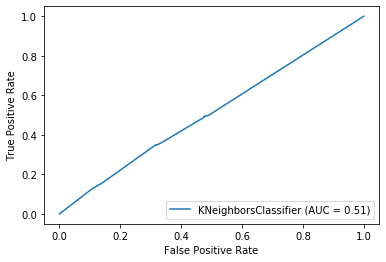

<Figure size 432x288 with 0 Axes>

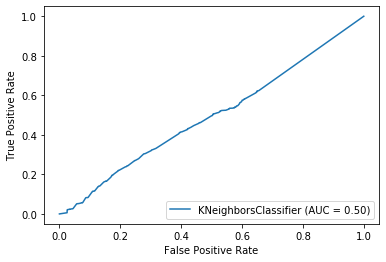

<Figure size 432x288 with 0 Axes>

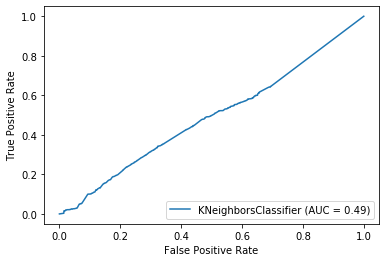

In [56]:
KNN(X_ros,y_ros,X_test.values,y_test.values)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[175189 129538]
 [  1708   1300]]
              precision    recall  f1-score   support

           0       0.99      0.57      0.73    304727
           1       0.01      0.43      0.02      3008

    accuracy                           0.57    307735
   macro avg       0.50      0.50      0.37    307735
weighted avg       0.98      0.57      0.72    307735


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[175193 129534]
 [  1708   1300]]
              precision    recall  f1-score   support

           0       0.99      0.57      0.73    304727
           1       0.01      0.43      0.02      3008

    accuracy                           0.57    307735
   macro avg       0.50      0.50      0.37    307735
weighted avg       0.98      0.57      0.72    307735


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[175197 129530]
 [  1708   1300]]
              precision    recall  f1-score   support

           0       0.99      

<Figure size 432x288 with 0 Axes>

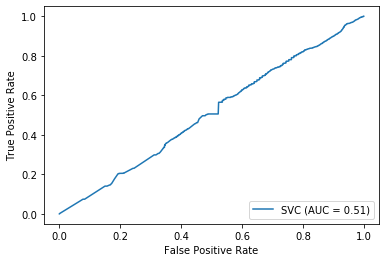

<Figure size 432x288 with 0 Axes>

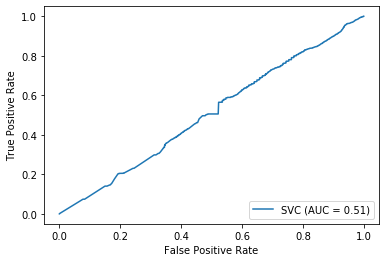

<Figure size 432x288 with 0 Axes>

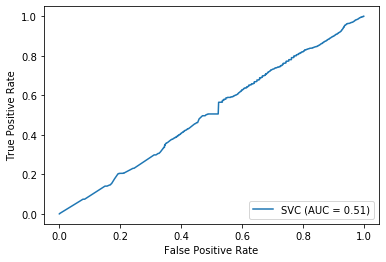

<Figure size 432x288 with 0 Axes>

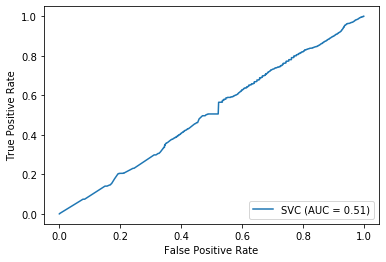

In [57]:
SVCL(X_ros,y_ros,X_test.values,y_test.values)

dep: 1
[0.16 0.   0.06 0.27 0.21 0.19 0.11]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.1476874  0.03874154 0.0425923  0.36934829 0.18168679 0.14759394
 0.07234973]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel

<Figure size 432x288 with 0 Axes>

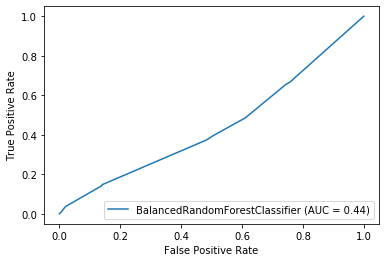

<Figure size 432x288 with 0 Axes>

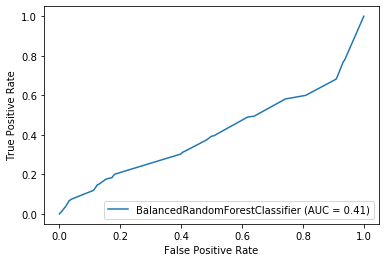

In [58]:
BalancedRF(X_ros,y_ros,X_test.values,y_test.values)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.7min remaining:  4.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   21.1s remaining:   21.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   27.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   22.8s remaining:   22.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   29.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 14.0min remaining: 14.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 15.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[213224  91503]
 [  2207    801]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[213231  91496]
 [  2207    801]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[213336  91391]
 [  2210    798]]
              prec

<Figure size 432x288 with 0 Axes>

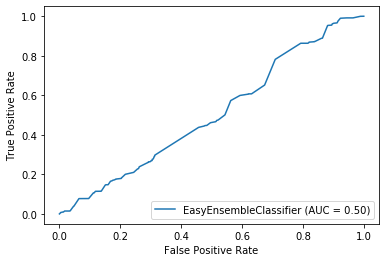

<Figure size 432x288 with 0 Axes>

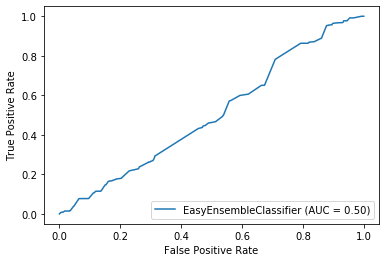

<Figure size 432x288 with 0 Axes>

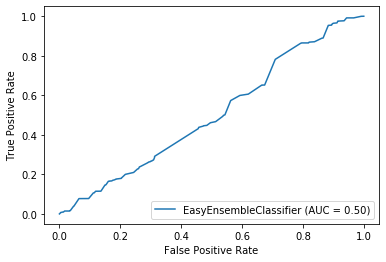

In [59]:
EasyEnsamble(X_ros,y_ros,X_test.values,y_test.values)

In [ ]:
CB(X_ros,y_ros,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MAT

<Figure size 432x288 with 0 Axes>

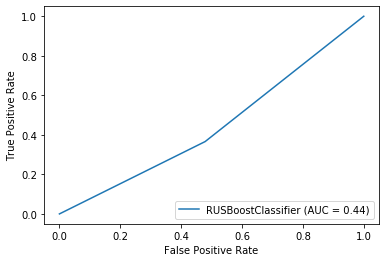

<Figure size 432x288 with 0 Axes>

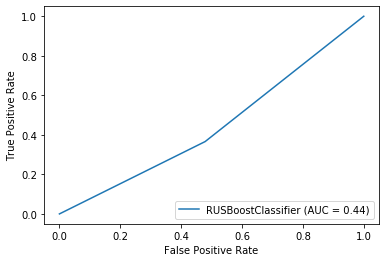

<Figure size 432x288 with 0 Axes>

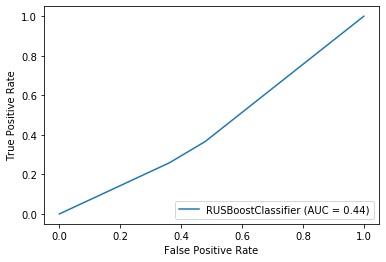

In [60]:
RUSBoost(X_ros,y_ros,X_test.values,y_test.values)

Counter({0: 1120777, 1: 109996})


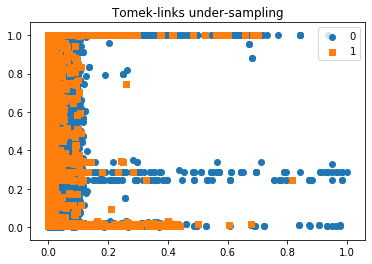

In [61]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority',n_jobs=-1)
X_tl, y_tl = tl.fit_sample(X_train.values, y_train.values)
print(Counter(y_tl))
plot_2d_space(X_tl, y_tl, 'Tomek-links under-sampling')

In [ ]:
pca = PCA(n_components=2)
X_tl_pca=pca.fit_transform(X_tl)
plot_2d_space(X_tl_pca, y_tl.T.ravel(),'PCA - 2 Components - TomekLinks')

dep: 1
[0.11 0.   0.03 0.24 0.21 0.22 0.19]

 RANDOM FOREST
CONFUSION MATRIX
[[304727      0]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50
dep: 2
[0.1194079  0.03640189 0.04296559 0.29211347 0.20359873 0.20363132
 0.1018811 ]

 RANDOM FOREST
CONFUSION MATRIX
[[304727      0]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel

<Figure size 432x288 with 0 Axes>

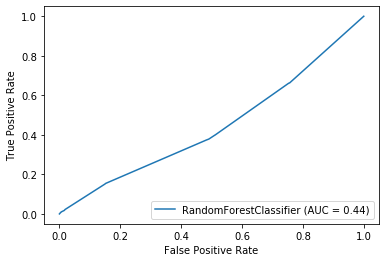

<Figure size 432x288 with 0 Axes>

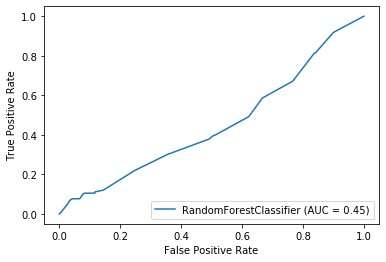

In [62]:
RandomForest(X_tl,y_tl,X_test,y_test)

In [63]:
adaboost(X_tl,y_tl,X_test,y_test)

[0.08 0.   0.02 0.86 0.02 0.   0.02]

 ADABOOST
CONFUSION MATRIX
[[304713     14]
 [  3007      1]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.07      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.53      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50


[0.08481354 0.21230417 0.04613602 0.41301107 0.18649398 0.
 0.05724127]

 XGBoost
CONFUSION MATRIX
[[301814   2913]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.98    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.98      0.98    307735


ROC CURVE: 0.50


<Figure size 432x288 with 0 Axes>

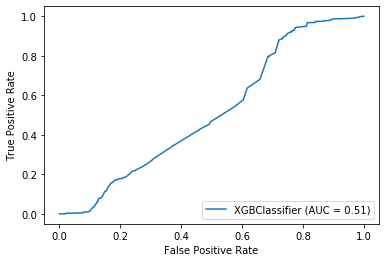

In [64]:
xgboost(X_tl,y_tl,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 DECISION TREE
CONFUSION MATRIX
[[304727      0]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50
[0.         0.50899694 0.         0.27998114 0.21102192 0.
 0.        ]

 DECISION TREE
CONFUSION MATRIX
[[304727      0]
 [  3008      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    304727
           1       0.00      0.00      0.00      3008

    accuracy                           0.99    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.99      0.99    307735


ROC CURVE: 0.50


<Figure size 432x288 with 0 Axes>

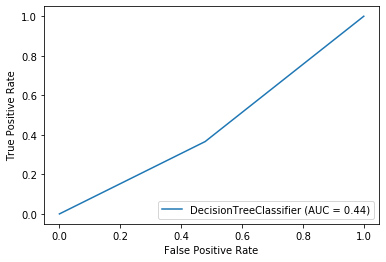

<Figure size 432x288 with 0 Axes>

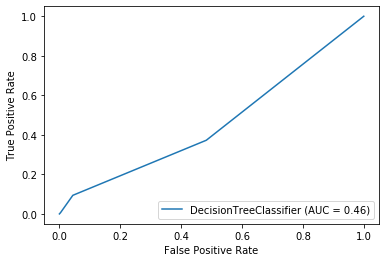

In [65]:
DT(X_tl,y_tl,X_test,y_test)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[290213  14514]
 [  2876    132]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    304727
           1       0.01      0.04      0.01      3008

    accuracy                           0.94    307735
   macro avg       0.50      0.50      0.49    307735
weighted avg       0.98      0.94      0.96    307735


ROC CURVE: 0.50

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[296353   8374]
 [  2934     74]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    304727
           1       0.01      0.02      0.01      3008

    accuracy                           0.96    307735
   macro avg       0.50      0.50      0.50    307735
weighted avg       0.98      0.96      0.97    307735


ROC CURVE: 0.50

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[297238   7489]
 [  2944     64]]
              precision    recall  f1-score   support

      

<Figure size 432x288 with 0 Axes>

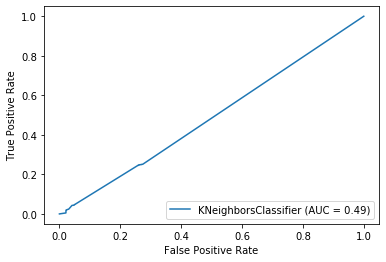

<Figure size 432x288 with 0 Axes>

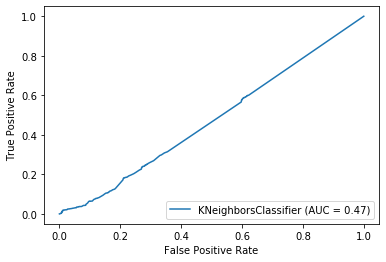

<Figure size 432x288 with 0 Axes>

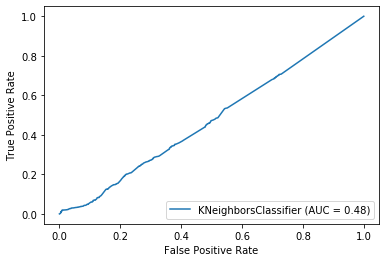

In [66]:
KNN(X_tl,y_tl,X_test.values,y_test.values)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[175207 129520]
 [  1708   1300]]
              precision    recall  f1-score   support

           0       0.99      0.57      0.73    304727
           1       0.01      0.43      0.02      3008

    accuracy                           0.57    307735
   macro avg       0.50      0.50      0.37    307735
weighted avg       0.98      0.57      0.72    307735


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[175209 129518]
 [  1708   1300]]
              precision    recall  f1-score   support

           0       0.99      0.57      0.73    304727
           1       0.01      0.43      0.02      3008

    accuracy                           0.57    307735
   macro avg       0.50      0.50      0.37    307735
weighted avg       0.98      0.57      0.72    307735


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[175220 129507]
 [  1708   1300]]
              precision    recall  f1-score   support

           0       0.99      

<Figure size 432x288 with 0 Axes>

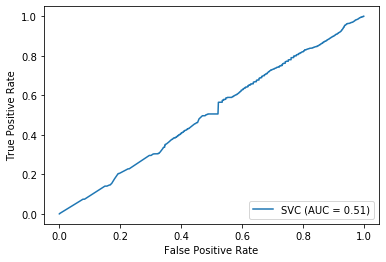

<Figure size 432x288 with 0 Axes>

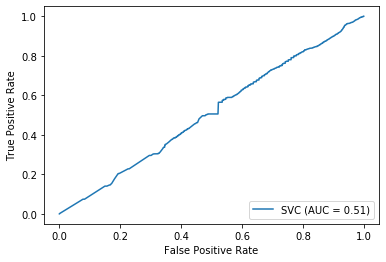

<Figure size 432x288 with 0 Axes>

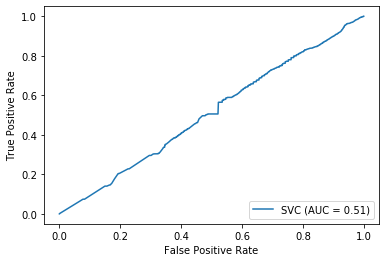

<Figure size 432x288 with 0 Axes>

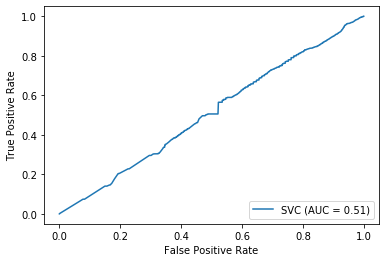

In [67]:
SVCL(X_tl,y_tl,X_test.values,y_test.values)

dep: 1
[0.16 0.   0.06 0.27 0.22 0.18 0.11]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157384 147343]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45
dep: 2
[0.16334127 0.04001217 0.04434311 0.35849699 0.17592765 0.14376954
 0.07410927]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[157368 147359]
 [  1882   1126]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.45      0.35    307735
weighted avg       0.98      0.52      0.67    307735


ROC CURVE: 0.45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel

<Figure size 432x288 with 0 Axes>

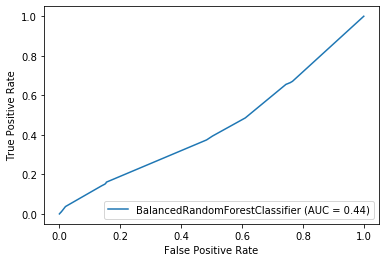

<Figure size 432x288 with 0 Axes>

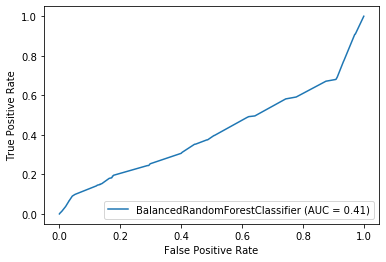

In [68]:
BalancedRF(X_tl,y_tl,X_test.values,y_test.values)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   22.7s remaining:   22.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   29.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   19.5s remaining:   19.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   25.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   19.7s remaining:   19.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   26.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   50.0s remaining:   50.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   56.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[213369  91358]
 [  2207    801]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[213217  91510]
 [  2205    803]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    304727
           1       0.01      0.27      0.02      3008

    accuracy                           0.70    307735
   macro avg       0.50      0.48      0.42    307735
weighted avg       0.98      0.70      0.81    307735


ROC CURVE: 0.48

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[214086  90641]
 [  2206    802]]
              prec

<Figure size 432x288 with 0 Axes>

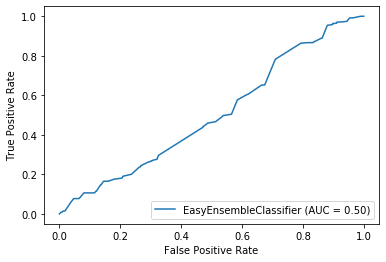

<Figure size 432x288 with 0 Axes>

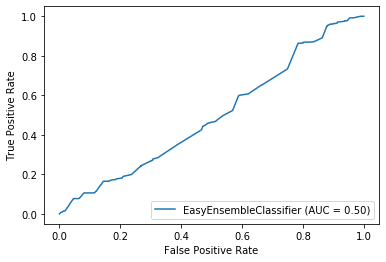

<Figure size 432x288 with 0 Axes>

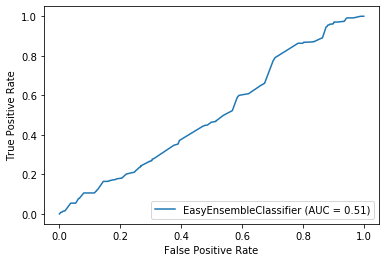

In [69]:
EasyEnsamble(X_tl,y_tl,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[158818 145909]
 [  1907   1101]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    304727
           1       0.01      0.37      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
[0. 0. 0. 1. 0. 0. 0.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MAT

<Figure size 432x288 with 0 Axes>

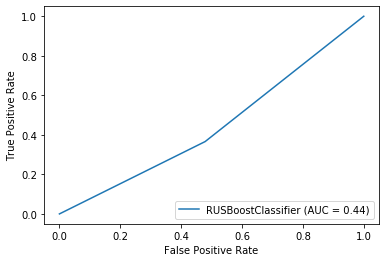

<Figure size 432x288 with 0 Axes>

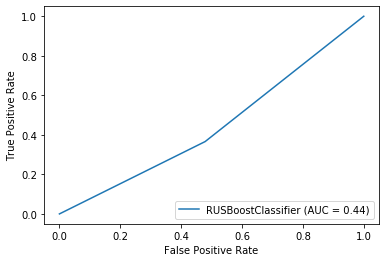

<Figure size 432x288 with 0 Axes>

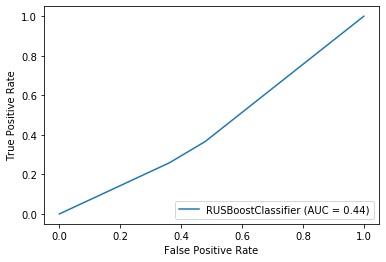

In [70]:
RUSBoost(X_tl,y_tl,X_test.values,y_test.values)

In [ ]:
CB(X_tl,y_tl,X_test.values,y_test.values)

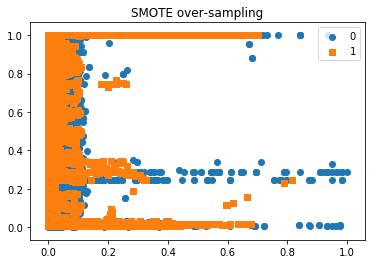

In [71]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority',random_state=rs,k_neighbors=10,n_jobs=-1)
X_sm, y_sm = smote.fit_sample(X_train.values, y_train.values)
plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

In [ ]:
pca = PCA(n_components=2)
X_sm_pca=pca.fit_transform(X_sm)
plot_2d_space(X_sm_pca, y_sm.T.ravel(),'PCA - 2 Components - SMOTE')

dep: 1
[0.18 0.   0.03 0.24 0.21 0.22 0.12]

 RANDOM FOREST
CONFUSION MATRIX
[[160156 144571]
 [  1937   1071]]
              precision    recall  f1-score   support

           0       0.99      0.53      0.69    304727
           1       0.01      0.36      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44
dep: 2
[0.16712459 0.03378794 0.0423536  0.34357488 0.17335518 0.17247022
 0.06733359]

 RANDOM FOREST
CONFUSION MATRIX
[[159941 144786]
 [  1937   1071]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.69    304727
           1       0.01      0.36      0.01      3008

    accuracy                           0.52    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.52      0.68    307735


ROC CURVE: 0.44


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel

<Figure size 432x288 with 0 Axes>

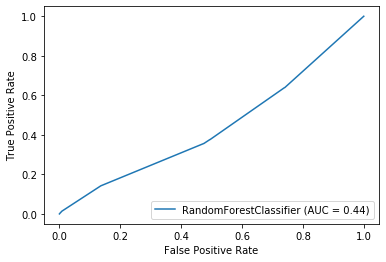

<Figure size 432x288 with 0 Axes>

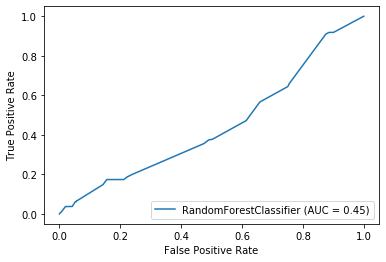

In [72]:
RandomForest(X_sm, y_sm,X_test,y_test)

In [73]:
adaboost(X_sm, y_sm,X_test,y_test)

[0.2  0.   0.02 0.74 0.02 0.   0.02]

 ADABOOST
CONFUSION MATRIX
[[184101 120626]
 [  2043    965]]
              precision    recall  f1-score   support

           0       0.99      0.60      0.75    304727
           1       0.01      0.32      0.02      3008

    accuracy                           0.60    307735
   macro avg       0.50      0.46      0.38    307735
weighted avg       0.98      0.60      0.74    307735


ROC CURVE: 0.46


[0.04649586 0.41533703 0.03485906 0.32862565 0.13947587 0.
 0.03520658]

 XGBoost
CONFUSION MATRIX
[[143209 161518]
 [  1705   1303]]
              precision    recall  f1-score   support

           0       0.99      0.47      0.64    304727
           1       0.01      0.43      0.02      3008

    accuracy                           0.47    307735
   macro avg       0.50      0.45      0.33    307735
weighted avg       0.98      0.47      0.63    307735


ROC CURVE: 0.45


<Figure size 432x288 with 0 Axes>

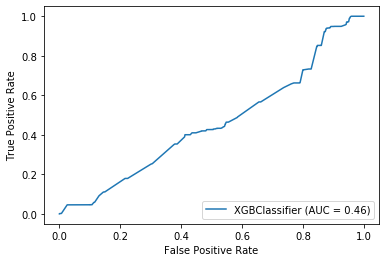

In [74]:
xgboost(X_sm, y_sm,X_test.values,y_test.values)

[0. 0. 0. 1. 0. 0. 0.]

 DECISION TREE
CONFUSION MATRIX
[[161720 143007]
 [  1962   1046]]
              precision    recall  f1-score   support

           0       0.99      0.53      0.69    304727
           1       0.01      0.35      0.01      3008

    accuracy                           0.53    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.53      0.68    307735


ROC CURVE: 0.44
[0.         0.         0.         0.85858528 0.14141472 0.
 0.        ]

 DECISION TREE
CONFUSION MATRIX
[[160566 144161]
 [  1942   1066]]
              precision    recall  f1-score   support

           0       0.99      0.53      0.69    304727
           1       0.01      0.35      0.01      3008

    accuracy                           0.53    307735
   macro avg       0.50      0.44      0.35    307735
weighted avg       0.98      0.53      0.68    307735


ROC CURVE: 0.44


<Figure size 432x288 with 0 Axes>

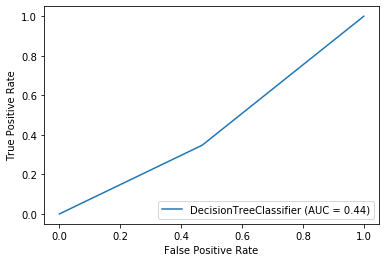

<Figure size 432x288 with 0 Axes>

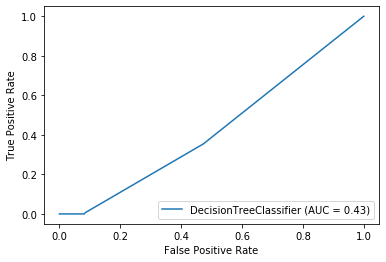

In [75]:
DT(X_sm, y_sm,X_test,y_test)

In [ ]:
KNN(X_sm, y_sm,X_test.values,y_test.values)

In [ ]:
SVCL(X_sm, y_sm,X_test.values,y_test.values)

In [ ]:
BalancedRF(X_sm, y_sm,X_test.values,y_test.values)

In [ ]:
EasyEnsamble(X_sm, y_sm,X_test.values,y_test.values) 

In [ ]:
CB(X_sm, y_sm,X_test.values,y_test.values)

In [ ]:
RUSBoost(X_sm, y_sm,X_test.values,y_test.values)


In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='auto',random_state=rs,n_jobs=-1)
X_smt, y_smt = smt.fit_sample(X_train, y_train)
plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [ ]:
pca = PCA(n_components=2)
X_smt_pca=pca.fit_transform(X_smt)
plot_2d_space(X_smt_pca, y_smt.T.ravel(),'PCA - 2 Components - SMOTETomek')

In [ ]:
RandomForest(X_smt, y_smt,X_test,y_test)

In [ ]:
adaboost(X_smt, y_smt,X_test,y_test)

In [ ]:
xgboost(X_smt, y_smt,X_test.values,y_test.values)

In [ ]:
DT(X_smt, y_smt,X_test,y_test)

In [ ]:
KNN(X_smt, y_smt,X_test.values,y_test.values)

In [ ]:
SVCL(X_smt, y_smt,X_test.values,y_test.values)

In [ ]:
BalancedRF(X_smt, y_smt,X_test.values,y_test.values)

In [ ]:
EasyEnsamble(X_smt, y_smt,X_test.values,y_test.values)

In [ ]:
CB(X_smt, y_smt,X_test.values,y_test.values)

In [ ]:
RUSBoost(X_smt, y_smt,X_test.values,y_test.values)

In [ ]:
time1 = time.time()
print('Time to finish the process: %1000.10f'%(time1-time0))